In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import kagglehub
import polars as pl
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.models import vit_b_16, ViT_B_16_Weights
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import time

/mnt/1EC2AF28C2AF035F/fac/M1/IP/aiimgdetect/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Fetch the dataset from Kaggle

In [3]:

# Download latest version
path = kagglehub.dataset_download("shreyasraghav/shutterstock-dataset-for-ai-vs-human-gen-image")

print("Path to dataset files:", path)
train_data_path = os.path.join(path, "train.csv")

Path to dataset files: /home/dan/.cache/kagglehub/datasets/shreyasraghav/shutterstock-dataset-for-ai-vs-human-gen-image/versions/2


# Create a dataloader

In [4]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")  # Ensure RGB
        label = torch.tensor([float(self.labels[idx])], dtype=torch.float)  # Binary labels

        if self.transform:
            image = self.transform(image)
            image = image.unsqueeze(0)  # Add batch dimension

        return image, label

def load_data(data: pl.DataFrame) -> DataLoader:
    image_paths = data['path'].to_list()
    labels = data['label'].to_list()

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    dataset = ImageDataset(image_paths, labels, transform=transform)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    return dataloader

# Setup the data loader

In [5]:
# setup the polars dataframe containing the path and label of the images
train_data = pl.read_csv(train_data_path)
# prepend the path with the path to the dataset
train_data = train_data.with_columns([pl.col("file_name").map_elements(lambda s: os.path.join(path, s), return_dtype=str).alias("path")])

In [6]:
dataloader = load_data(train_data)
#display the first image
# img, label = next(iter(dataloader))
# print(img.shape, label.shape)
# plt.imshow(img[0].permute(1, 2, 0))

# Create the model architecture

In [7]:
class BinaryViT(nn.Module):
    def __init__(self):
        super(BinaryViT, self).__init__()
        self.vit = vit_b_16()
        # replacing the head
        self.vit.heads = nn.Sequential(nn.Linear(self.vit.hidden_dim, 1))
    def forward(self, x):
        x = self.vit(x).squeeze(1)
        return x


# Training

In [10]:
from dataclasses import dataclass
@dataclass
class TrainReport:
    accuracies  : list[float]
    losses      : list[float]

def train(model: nn.Module, dataloader, criterion, optimizer, epochs, device) -> TrainReport:
    report = TrainReport([], [])
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            report.losses.append(loss.item())
            #outputs ar in range 0-1, for report just use 0.5 as threshold
            report.accuracies.append(((outputs > 0.5) == labels).float().mean().item())

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(dataloader)}")
    return report

In [12]:
data_for_train = torch.utils.data.Subset(dataloader.dataset, range(10))
model = BinaryViT()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
print('Training...')
start = time.time()
report = train(model, data_for_train, criterion, optimizer, 10, device)
print(f"Training took {time.time()-start:.2f} seconds")


Using device: cpu
Training...
Epoch 1/10, Loss: 2.130525054689497
Epoch 2/10, Loss: 0.7689725756645203
Epoch 3/10, Loss: 0.6439700663089752
Epoch 4/10, Loss: 0.5485937625169754
Epoch 5/10, Loss: 0.42736772894859315
Epoch 6/10, Loss: 0.25653141364455223
Epoch 7/10, Loss: 0.8012337541440502
Epoch 8/10, Loss: 0.6632097719237209
Epoch 9/10, Loss: 0.6509559154510498
Epoch 10/10, Loss: 0.3827800817787647
Training took 260.13 seconds


# Plots

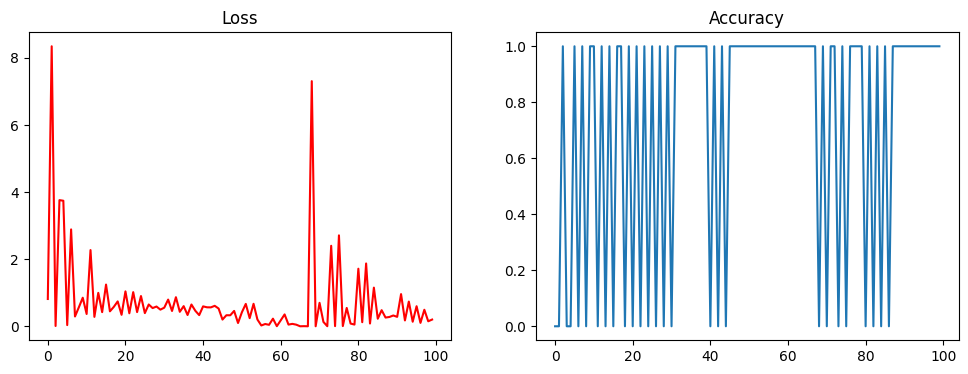

In [14]:
# plot the report loss and accuracy

def plot_report(report: TrainReport):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(report.losses, color='red')
    ax[0].set_title("Loss")
    ax[1].plot(report.accuracies)
    ax[1].set_title("Accuracy")
    plt.show()

plot_report(report)